In [1]:
import numpy as np
import itertools
import json

from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import calibration_curve, _SigmoidCalibration, _sigmoid_calibration
from ampligraph.evaluation import evaluate_performance, mr_score, mrr_score, hits_at_n_score, generate_corruptions_for_eval
from sklearn.metrics import brier_score_loss, log_loss
from scipy.special import expit

from ampligraph.datasets import load_wn18rr
from ampligraph.latent_features.models import TransE, ComplEx

In [2]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
X = load_wn18rr()

In [5]:
import types
from functools import partial
import tensorflow as tf
from sklearn.utils import check_random_state
from tqdm import tqdm
from ampligraph.datasets import AmpligraphDatasetAdapter, NumpyDatasetAdapter
from ampligraph.evaluation import generate_corruptions_for_fit, to_idx, generate_corruptions_for_eval, \
    hits_at_n_score, mrr_score


def generate_corruptions_triples(self, X_pos, batches_count, epochs):
    try:
        tf.reset_default_graph()
        self.rnd = check_random_state(self.seed)
        tf.random.set_random_seed(self.seed)

        self._load_model_from_trained_params()

        dataset_handle = NumpyDatasetAdapter()
        dataset_handle.use_mappings(self.rel_to_idx, self.ent_to_idx)

        dataset_handle.set_data(X_pos, "pos")

        batch_size_pos = int(np.ceil(dataset_handle.get_size("pos") / batches_count))

        gen_fn = partial(dataset_handle.get_next_train_batch, batch_size=batch_size_pos, dataset_type="pos")
        dataset = tf.data.Dataset.from_generator(gen_fn,
                                                 output_types=tf.int32,
                                                 output_shapes=(None, 3))
        dataset = dataset.repeat().prefetch(1)
        dataset_iter = tf.data.make_one_shot_iterator(dataset)

        x_pos_tf = dataset_iter.get_next()

        e_s, e_p, e_o = self._lookup_embeddings(x_pos_tf)
        scores_pos = self._fn(e_s, e_p, e_o)

        x_neg_tf = generate_corruptions_for_fit(x_pos_tf,
                                                entities_list=None,
                                                eta=1,
                                                corrupt_side='s+o',
                                                entities_size=0,
                                                rnd=self.seed)

        epoch_iterator_with_progress = tqdm(range(1, epochs + 1), disable=(not self.verbose), unit='epoch')

        scores_list = []
        with tf.Session(config=self.tf_config) as sess:
            sess.run(tf.global_variables_initializer())
            for _ in epoch_iterator_with_progress:
                losses = []
                for batch in range(batches_count):
                    scores_list.append(sess.run(x_neg_tf))

        dataset_handle.cleanup()
        return np.concatenate(scores_list)
    
    except Exception as e:
        dataset_handle.cleanup()
        

def generate_corruptions(self, X_pos, batches_count, epochs):
    try:
        tf.reset_default_graph()
        self.rnd = check_random_state(self.seed)
        tf.random.set_random_seed(self.seed)

        self._load_model_from_trained_params()

        dataset_handle = NumpyDatasetAdapter()
        dataset_handle.use_mappings(self.rel_to_idx, self.ent_to_idx)

        dataset_handle.set_data(X_pos, "pos")

        batch_size_pos = int(np.ceil(dataset_handle.get_size("pos") / batches_count))

        gen_fn = partial(dataset_handle.get_next_train_batch, batch_size=batch_size_pos, dataset_type="pos")
        dataset = tf.data.Dataset.from_generator(gen_fn,
                                                 output_types=tf.int32,
                                                 output_shapes=(None, 3))
        dataset = dataset.repeat().prefetch(1)
        dataset_iter = tf.data.make_one_shot_iterator(dataset)

        x_pos_tf = dataset_iter.get_next()

        e_s, e_p, e_o = self._lookup_embeddings(x_pos_tf)
        scores_pos = self._fn(e_s, e_p, e_o)

        x_neg_tf = generate_corruptions_for_fit(x_pos_tf,
                                                entities_list=None,
                                                eta=1,
                                                corrupt_side='s+o',
                                                entities_size=0,
                                                rnd=self.seed)

        e_s_neg, e_p_neg, e_o_neg = self._lookup_embeddings(x_neg_tf)
        scores = self._fn(e_s_neg, e_p_neg, e_o_neg)

        epoch_iterator_with_progress = tqdm(range(1, epochs + 1), disable=(not self.verbose), unit='epoch')

        scores_list = []
        with tf.Session(config=self.tf_config) as sess:
            sess.run(tf.global_variables_initializer())
            for _ in epoch_iterator_with_progress:
                losses = []
                for batch in range(batches_count):
                    scores_list.append(sess.run(scores))

        dataset_handle.cleanup()
        return np.concatenate(scores_list)
    
    except Exception as e:
        dataset_handle.cleanup()
        raise e

In [6]:
def pos_iso(cal_model, pos_scores, neg_scores, positive_base_rate):
    weigths_pos = len(neg_scores) / len(pos_scores)
    weights_neg = (1.0 - positive_base_rate) / positive_base_rate
    weights = np.concatenate((np.full(pos_scores.shape, weigths_pos),
                              np.full(neg_scores.shape, weights_neg))).astype(float)
    target =  np.concatenate((np.ones(pos_scores.shape), np.zeros(neg_scores.shape))).astype(float)
    x = np.concatenate((pos_scores, neg_scores)).astype(float)
    
    cal_model.fit(x, target, sample_weight=weights)
    return cal_model

In [7]:
model = ComplEx(batches_count=10, seed=0, epochs=4000, k=200, eta=20,
                # Use adam optimizer with learning rate 1e-3
                optimizer='adam', optimizer_params={'lr':0.0005},
                # Use pairwise loss with margin 0.5
                loss='multiclass_nll',
                # Use L2 regularizer with regularizer weight 1e-5
                regularizer='LP', regularizer_params={'p':3, 'lambda':0.05}, 
                # Enable stdout messages (set to false if you don't want to display)
                verbose=True)

filter_triples = np.concatenate((X['train'], X['valid'], X['test']))

# Fit the model on training and validation set
model.fit(X['train'], 
          early_stopping = True,
          early_stopping_params = \
                  {
                      'x_valid': X['valid'],       # validation set
                      'criteria':'mrr',         # Uses hits10 criteria for early stopping
                      'burn_in': 100,              # early stopping kicks in after 100 epochs
                      'check_interval':100,         # validates every 20th epoch
                      'stop_interval':2,           # stops if 5 successive validation checks are bad.
                      'x_filter': filter_triples,          # Use filter for filtering out positives 
                      'corruption_entities':'all', # corrupt using all entities
                      'corrupt_side':'s+o'         # corrupt subject and object (but not at once)
                  }
          )



WARNING - From /home/ptabacof/.conda/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
WARNING - From /home/ptabacof/.conda/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:429: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
WARNING - From /home/ptabacof/.

Average Loss:   0.150882 — Best validation (mrr): 0.441295:  35%|███▍      | 1399/4000 [19:02<23:07,  1.87epoch/s]  

In [8]:
ranks = evaluate_performance(X['test'], 
                             model=model, 
                             filter_triples=filter_triples,
                             use_default_protocol=True, 
                             verbose=False)


100%|██████████| 2924/2924 [00:25<00:00, 112.62it/s]

In [9]:
mrr_score(ranks),  hits_at_n_score(ranks, n=10), mr_score(ranks)

(0.5059065038686544, 0.5827633378932968, 4110.870041039671)

In [10]:
model.generate_corruptions_triples = types.MethodType(generate_corruptions_triples, model)
fake_negatives = model.generate_corruptions_triples(X['test'], batches_count=10, epochs=1000)

WARNING - From /home/ptabacof/AmpliGraph-Lab/ampligraph/evaluation/protocol.py:348: multinomial (from tensorflow.python.ops.random_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.random.categorical instead.



100%|██████████| 1000/1000 [00:17<00:00, 56.14epoch/s]

In [11]:
idx_to_ent = {v: k for k, v in model.ent_to_idx.items()} 
idx_to_rel = {v: k for k, v in model.rel_to_idx.items()} 

In [12]:
results = []

for pbr in np.linspace(0.05, 0.95, 19):
    
    fake_idx = np.random.randint(len(fake_negatives), size=int(len(X['test'])/pbr-len(X['test'])))
    fake_test = fake_negatives[fake_idx, :]

    s = np.vectorize(idx_to_ent.get)(fake_test[:, 0])
    p = np.vectorize(idx_to_rel.get)(fake_test[:, 1])
    o = np.vectorize(idx_to_ent.get)(fake_test[:, 2])

    fake_test = np.vstack((s, p, o)).T
    X_test = np.vstack((X['test'], fake_test))
    X_test_labels = np.concatenate((np.ones(len(X['test'])), np.zeros(len(fake_idx))))
    
    scores = model.predict(X_test)

    model.calibrate(X['valid'], batches_count=10, epochs=1000, positive_base_rate=pbr)
    print("pos", model.calibration_parameters)
    probas1 = model.predict_proba(X_test)

    model.generate_corruptions = types.MethodType(generate_corruptions, model)
    corruptions = model.generate_corruptions(X['valid'], batches_count=10, epochs=1000)
    val_pos_scores = np.squeeze(model.predict(X['valid']))
    iso_pos = pos_iso(IsotonicRegression(out_of_bounds='clip'), val_pos_scores, corruptions, positive_base_rate=pbr)
    probas4 = iso_pos.predict(np.squeeze(scores).astype(float))

    sc_pos = pos_iso(_SigmoidCalibration(), val_pos_scores, corruptions, positive_base_rate=pbr)
    print("pos sc", sc_pos.a_, sc_pos.b_)
    probas5 = sc_pos.predict(np.squeeze(scores).astype(float))

    results.append({
        'pbr': pbr,
        'brier_score_baseline': brier_score_loss(X_test_labels, np.array([pbr]*len(X_test_labels))),
        'log_loss_baseline': log_loss(X_test_labels, np.array([pbr]*len(X_test_labels)), eps=1e-7),
        'brier_score_scores': brier_score_loss(X_test_labels, expit(scores)),
        'log_loss_scores': log_loss(X_test_labels, expit(scores), eps=1e-7),
        'brier_score_probas_pos': brier_score_loss(X_test_labels, probas1),
        'log_loss_probas_pos': log_loss(X_test_labels, probas1, eps=1e-7),
        'brier_score_probas_pos_iso': brier_score_loss(X_test_labels, probas4),
        'log_loss_probas_pos_iso': log_loss(X_test_labels, probas4, eps=1e-7),
        'brier_score_probas_pos_sc': brier_score_loss(X_test_labels, probas5),
        'log_loss_probas_pos_sc': log_loss(X_test_labels, probas5, eps=1e-7)
    })
        
    print(json.dumps(results[-1], indent=2))

WARNING - From /home/ptabacof/.conda/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/ops/losses/losses_impl.py:209: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.



Calibration Loss:   2.939281:  14%|█▍        | 139/1000 [00:06<00:39, 22.02epoch/s]


Calibration Loss:   1.691552:  28%|██▊       | 280/1000 [00:12<00:30, 23.25epoch/s]


Calibration Loss:   1.265876:  42%|████▏     | 421/1000 [00:18<00:25, 22.54epoch/s]


Calibration Loss:   1.067494:  56%|█████▌    | 562/1000 [00:25<00:19, 22.78epoch/s]


Calibration Loss:   0.941642:  70%|███████   | 703/1000 [00:31<00:13, 22.43epoch/s]


Calibration Loss:   1.024675:  84%|████████▍ | 844/1000 [00:37<00:06, 22.47epoch/s]


Calibration Loss:   0.948057:  98%|█████████▊| 985/1000 [00:43<00:00, 23.09epoch/s]


Calibration Loss:   0.994767: 100%|██████████| 1000/1000 [00:44<00:00, 22.34epoch/s]

pos [-1.3637608, 4.143026]



100%|██████████| 1000/1000 [00:23<00:00, 41.81epoch/s]

pos sc -1.3770990166316786 4.196302495243854
{
  "pbr": 0.05,
  "brier_score_baseline": 0.0475,
  "log_loss_baseline": 0.19851524334587262,
  "brier_score_scores": 0.2568110505003484,
  "log_loss_scores": 0.7136219669529983,
  "brier_score_probas_pos": 0.020849239452201566,
  "log_loss_probas_pos": 0.0961096230977699,
  "brier_score_probas_pos_iso": 0.020519979569570006,
  "log_loss_probas_pos_iso": 0.09382469259868499,
  "brier_score_probas_pos_sc": 0.020861861288581324,
  "log_loss_probas_pos_sc": 0.09608998972153866
}



Calibration Loss:   1.540864:  14%|█▍        | 139/1000 [00:06<00:38, 22.20epoch/s]


Calibration Loss:   1.012187:  28%|██▊       | 280/1000 [00:12<00:30, 23.83epoch/s]


Calibration Loss:   0.863981:  42%|████▏     | 421/1000 [00:19<00:25, 22.44epoch/s]


Calibration Loss:   0.798514:  56%|█████▌    | 562/1000 [00:25<00:20, 21.56epoch/s]


Calibration Loss:   0.742343:  70%|███████   | 703/1000 [00:31<00:13, 21.74epoch/s]


Calibration Loss:   0.801222:  84%|████████▍ | 844/1000 [00:38<00:07, 21.80epoch/s]


Calibration Loss:   0.756102:  98%|█████████▊| 985/1000 [00:44<00:00, 22.46epoch/s]


Calibration Loss:   0.787897: 100%|██████████| 1000/1000 [00:44<00:00, 22.01epoch/s]

pos [-1.4780498, 3.5005958]



100%|██████████| 1000/1000 [00:23<00:00, 41.73epoch/s]

pos sc -1.472908780134882 3.5221600490664775
{
  "pbr": 0.1,
  "brier_score_baseline": 0.09000000000000004,
  "log_loss_baseline": 0.3250829733914482,
  "brier_score_scores": 0.24555896338360764,
  "log_loss_scores": 0.6841810098804594,
  "brier_score_probas_pos": 0.03636914220340291,
  "log_loss_probas_pos": 0.15493801391975076,
  "brier_score_probas_pos_iso": 0.03614471181624121,
  "log_loss_probas_pos_iso": 0.1521408104572826,
  "brier_score_probas_pos_sc": 0.03640310572168199,
  "log_loss_probas_pos_sc": 0.15491313135669244
}



Calibration Loss:   1.080294:  14%|█▍        | 138/1000 [00:07<00:43, 19.63epoch/s]


Calibration Loss:   0.767581:  28%|██▊       | 278/1000 [00:14<00:35, 20.41epoch/s]


Calibration Loss:   0.693052:  42%|████▏     | 417/1000 [00:20<00:28, 20.32epoch/s]


Calibration Loss:   0.669299:  55%|█████▌    | 552/1000 [00:27<00:22, 19.73epoch/s]


Calibration Loss:   0.663303:  69%|██████▉   | 693/1000 [00:34<00:12, 23.68epoch/s]


Calibration Loss:   0.666925:  83%|████████▎ | 834/1000 [00:40<00:07, 22.75epoch/s]


Calibration Loss:   0.648144:  98%|█████████▊| 975/1000 [00:46<00:01, 22.69epoch/s]


Calibration Loss:   0.677043: 100%|██████████| 1000/1000 [00:47<00:00, 20.92epoch/s]

pos [-1.5243828, 3.0779312]



100%|██████████| 1000/1000 [00:23<00:00, 42.67epoch/s]

pos sc -1.5163725811689106 3.094527565738268
{
  "pbr": 0.15,
  "brier_score_baseline": 0.1275017955163392,
  "log_loss_baseline": 0.42271353709818665,
  "brier_score_scores": 0.23717703495914738,
  "log_loss_scores": 0.660573404487551,
  "brier_score_probas_pos": 0.05016516937344585,
  "log_loss_probas_pos": 0.20186755746713617,
  "brier_score_probas_pos_iso": 0.04993478143571199,
  "log_loss_probas_pos_iso": 0.19846535455226852,
  "brier_score_probas_pos_sc": 0.05019772538442764,
  "log_loss_probas_pos_sc": 0.20182937518391755
}



Calibration Loss:   0.825626:  14%|█▍        | 139/1000 [00:06<00:37, 22.83epoch/s]


Calibration Loss:   0.645112:  28%|██▊       | 280/1000 [00:12<00:31, 22.83epoch/s]


Calibration Loss:   0.617997:  42%|████▏     | 421/1000 [00:18<00:26, 22.16epoch/s]


Calibration Loss:   0.602532:  56%|█████▌    | 562/1000 [00:25<00:19, 22.56epoch/s]


Calibration Loss:   0.576713:  70%|███████   | 705/1000 [00:31<00:13, 22.01epoch/s]


Calibration Loss:   0.607606:  85%|████████▍ | 846/1000 [00:37<00:06, 22.45epoch/s]


Calibration Loss:   0.583300:  99%|█████████▊| 987/1000 [00:43<00:00, 23.18epoch/s]


Calibration Loss:   0.601439: 100%|██████████| 1000/1000 [00:44<00:00, 22.60epoch/s]

pos [-1.547202, 2.752467]



100%|██████████| 1000/1000 [00:23<00:00, 43.11epoch/s]

pos sc -1.5381142385096445 2.76609741545082
{
  "pbr": 0.2,
  "brier_score_baseline": 0.16000000000000011,
  "log_loss_baseline": 0.5004024235381878,
  "brier_score_scores": 0.2261396024580193,
  "log_loss_scores": 0.6337444701964803,
  "brier_score_probas_pos": 0.06364923420432608,
  "log_loss_probas_pos": 0.243691011893351,
  "brier_score_probas_pos_iso": 0.06367382613836424,
  "log_loss_probas_pos_iso": 0.2403626407682478,
  "brier_score_probas_pos_sc": 0.06367048856362936,
  "log_loss_probas_pos_sc": 0.24361130614525978
}



Calibration Loss:   0.680145:  14%|█▍        | 139/1000 [00:06<00:37, 22.86epoch/s]


Calibration Loss:   0.564344:  28%|██▊       | 280/1000 [00:12<00:32, 22.32epoch/s]


Calibration Loss:   0.554632:  42%|████▏     | 421/1000 [00:18<00:25, 23.09epoch/s]


Calibration Loss:   0.544513:  56%|█████▌    | 562/1000 [00:25<00:18, 23.12epoch/s]


Calibration Loss:   0.524717:  70%|███████   | 703/1000 [00:31<00:12, 23.42epoch/s]


Calibration Loss:   0.548417:  84%|████████▍ | 844/1000 [00:37<00:06, 23.64epoch/s]


Calibration Loss:   0.529085:  98%|█████████▊| 985/1000 [00:43<00:00, 22.31epoch/s]


Calibration Loss:   0.543652: 100%|██████████| 1000/1000 [00:44<00:00, 22.25epoch/s]

pos [-1.5581282, 2.4792168]



100%|██████████| 1000/1000 [00:23<00:00, 42.44epoch/s]

pos sc -1.5483698428483426 2.4905487552558614
{
  "pbr": 0.25,
  "brier_score_baseline": 0.1875,
  "log_loss_baseline": 0.5623351446188082,
  "brier_score_scores": 0.21641102091752143,
  "log_loss_scores": 0.60702487555342,
  "brier_score_probas_pos": 0.0748543194464494,
  "log_loss_probas_pos": 0.2761159535429764,
  "brier_score_probas_pos_iso": 0.07468242114982725,
  "log_loss_probas_pos_iso": 0.2721134081488141,
  "brier_score_probas_pos_sc": 0.07487485390728718,
  "log_loss_probas_pos_sc": 0.27604136161543513
}



Calibration Loss:   0.582466:  14%|█▍        | 139/1000 [00:06<00:37, 23.02epoch/s]


Calibration Loss:   0.506645:  28%|██▊       | 280/1000 [00:12<00:31, 23.17epoch/s]


Calibration Loss:   0.504934:  42%|████▏     | 421/1000 [00:18<00:25, 22.57epoch/s]


Calibration Loss:   0.497064:  56%|█████▌    | 562/1000 [00:25<00:19, 22.63epoch/s]


Calibration Loss:   0.481551:  70%|███████   | 703/1000 [00:31<00:12, 23.53epoch/s]


Calibration Loss:   0.500173:  84%|████████▍ | 844/1000 [00:37<00:07, 22.27epoch/s]


Calibration Loss:   0.484402:  98%|█████████▊| 985/1000 [00:43<00:00, 23.16epoch/s]


Calibration Loss:   0.496368: 100%|██████████| 1000/1000 [00:44<00:00, 22.55epoch/s]

pos [-1.5617716, 2.2372873]



100%|██████████| 1000/1000 [00:23<00:00, 42.71epoch/s]

pos sc -1.5515757283574025 2.246818324084367
{
  "pbr": 0.3,
  "brier_score_baseline": 0.21000820849579316,
  "log_loss_baseline": 0.6108816896571998,
  "brier_score_scores": 0.2060962131308113,
  "log_loss_scores": 0.5764550127199191,
  "brier_score_probas_pos": 0.08483543393444037,
  "log_loss_probas_pos": 0.2981638639278584,
  "brier_score_probas_pos_iso": 0.08485212126540581,
  "log_loss_probas_pos_iso": 0.2972948199678431,
  "brier_score_probas_pos_sc": 0.08484621566935444,
  "log_loss_probas_pos_sc": 0.29813216323040365
}



Calibration Loss:   0.512200:  14%|█▍        | 139/1000 [00:06<00:37, 22.92epoch/s]


Calibration Loss:   0.461719:  28%|██▊       | 280/1000 [00:12<00:32, 22.37epoch/s]


Calibration Loss:   0.463094:  42%|████▏     | 421/1000 [00:18<00:25, 22.72epoch/s]


Calibration Loss:   0.456352:  56%|█████▌    | 562/1000 [00:25<00:19, 22.87epoch/s]


Calibration Loss:   0.444080:  70%|███████   | 703/1000 [00:31<00:12, 23.42epoch/s]


Calibration Loss:   0.458935:  84%|████████▍ | 844/1000 [00:37<00:06, 22.76epoch/s]


Calibration Loss:   0.445870:  98%|█████████▊| 985/1000 [00:43<00:00, 22.72epoch/s]


Calibration Loss:   0.455848: 100%|██████████| 1000/1000 [00:44<00:00, 23.01epoch/s]

pos [-1.5603697, 2.0150652]



100%|██████████| 1000/1000 [00:23<00:00, 43.03epoch/s]

pos sc -1.5499035717117513 2.023131791929798
{
  "pbr": 0.35,
  "brier_score_baseline": 0.2275035910940867,
  "log_loss_baseline": 0.6474540491281017,
  "brier_score_scores": 0.19689693578925258,
  "log_loss_scores": 0.5504801624182024,
  "brier_score_probas_pos": 0.09374283585429442,
  "log_loss_probas_pos": 0.3193776267833207,
  "brier_score_probas_pos_iso": 0.09347955906159211,
  "log_loss_probas_pos_iso": 0.3181694080072925,
  "brier_score_probas_pos_sc": 0.09374909286829528,
  "log_loss_probas_pos_sc": 0.31936186720626125
}



Calibration Loss:   0.458998:  14%|█▍        | 139/1000 [00:06<00:37, 23.19epoch/s]


Calibration Loss:   0.424176:  28%|██▊       | 280/1000 [00:12<00:32, 22.29epoch/s]


Calibration Loss:   0.426243:  42%|████▏     | 421/1000 [00:18<00:25, 22.97epoch/s]


Calibration Loss:   0.420226:  56%|█████▌    | 562/1000 [00:25<00:19, 22.59epoch/s]


Calibration Loss:   0.410486:  70%|███████   | 703/1000 [00:31<00:12, 22.94epoch/s]


Calibration Loss:   0.422437:  84%|████████▍ | 844/1000 [00:37<00:06, 22.31epoch/s]


Calibration Loss:   0.411518:  98%|█████████▊| 985/1000 [00:43<00:00, 23.89epoch/s]


Calibration Loss:   0.419922: 100%|██████████| 1000/1000 [00:44<00:00, 22.93epoch/s]

pos [-1.5551038, 1.8051354]



100%|██████████| 1000/1000 [00:23<00:00, 48.85epoch/s]

pos sc -1.5445347779536682 1.8120003634723798
{
  "pbr": 0.39999999999999997,
  "brier_score_baseline": 0.24000000000000005,
  "log_loss_baseline": 0.6730116670092565,
  "brier_score_scores": 0.18718252363998983,
  "log_loss_scores": 0.5301707677982498,
  "brier_score_probas_pos": 0.1039260584089704,
  "log_loss_probas_pos": 0.34882931267279654,
  "brier_score_probas_pos_iso": 0.10420385745400676,
  "log_loss_probas_pos_iso": 0.34633050987964026,
  "brier_score_probas_pos_sc": 0.10391817126829968,
  "log_loss_probas_pos_sc": 0.3486946342339374
}



Calibration Loss:   0.416877:  14%|█▍        | 139/1000 [00:06<00:38, 22.42epoch/s]


Calibration Loss:   0.391001:  28%|██▊       | 280/1000 [00:12<00:32, 22.16epoch/s]


Calibration Loss:   0.392781:  42%|████▏     | 421/1000 [00:18<00:25, 22.50epoch/s]


Calibration Loss:   0.387314:  56%|█████▌    | 562/1000 [00:25<00:18, 23.52epoch/s]


Calibration Loss:   0.379596:  70%|███████   | 703/1000 [00:31<00:13, 22.26epoch/s]


Calibration Loss:   0.389242:  84%|████████▍ | 844/1000 [00:37<00:06, 22.47epoch/s]


Calibration Loss:   0.380080:  98%|█████████▊| 985/1000 [00:43<00:00, 22.43epoch/s]


Calibration Loss:   0.387201: 100%|██████████| 1000/1000 [00:44<00:00, 22.77epoch/s]

pos [-1.5465988, 1.6021593]



100%|██████████| 1000/1000 [00:23<00:00, 42.64epoch/s]

pos sc -1.5360813849681594 1.6080504444803667
{
  "pbr": 0.44999999999999996,
  "brier_score_baseline": 0.24750538710173933,
  "log_loss_baseline": 0.688149624048114,
  "brier_score_scores": 0.17700993447368704,
  "log_loss_scores": 0.501411309648796,
  "brier_score_probas_pos": 0.11036366455649914,
  "log_loss_probas_pos": 0.3592311542924928,
  "brier_score_probas_pos_iso": 0.11022892112922614,
  "log_loss_probas_pos_iso": 0.3575376606690241,
  "brier_score_probas_pos_sc": 0.11035725706798925,
  "log_loss_probas_pos_sc": 0.3591318871475941
}



Calibration Loss:   0.381773:  14%|█▍        | 139/1000 [00:06<00:37, 23.01epoch/s]


Calibration Loss:   0.360579:  28%|██▊       | 280/1000 [00:12<00:32, 22.48epoch/s]


Calibration Loss:   0.361694:  42%|████▏     | 421/1000 [00:18<00:24, 23.72epoch/s]


Calibration Loss:   0.356661:  56%|█████▌    | 562/1000 [00:25<00:18, 23.21epoch/s]


Calibration Loss:   0.350588:  70%|███████   | 703/1000 [00:31<00:12, 23.41epoch/s]


Calibration Loss:   0.358364:  84%|████████▍ | 844/1000 [00:37<00:06, 22.79epoch/s]


Calibration Loss:   0.350675:  98%|█████████▊| 985/1000 [00:43<00:00, 23.48epoch/s]


Calibration Loss:   0.356723: 100%|██████████| 1000/1000 [00:43<00:00, 22.75epoch/s]

pos [-1.5351291, 1.4018142]



100%|██████████| 1000/1000 [00:23<00:00, 50.97epoch/s]

pos sc -1.5247371612318643 1.4068708467922328
{
  "pbr": 0.49999999999999994,
  "brier_score_baseline": 0.25,
  "log_loss_baseline": 0.6931471805599454,
  "brier_score_scores": 0.16757495944155323,
  "log_loss_scores": 0.47933703434422276,
  "brier_score_probas_pos": 0.11653217369266897,
  "log_loss_probas_pos": 0.37528544790125057,
  "brier_score_probas_pos_iso": 0.11608968470445816,
  "log_loss_probas_pos_iso": 0.3710316732930298,
  "brier_score_probas_pos_sc": 0.1165217907082264,
  "log_loss_probas_pos_sc": 0.37513056515440346
}



Calibration Loss:   0.351018:  14%|█▍        | 139/1000 [00:06<00:38, 22.20epoch/s]


Calibration Loss:   0.331420:  28%|██▊       | 280/1000 [00:12<00:31, 22.76epoch/s]


Calibration Loss:   0.332152:  42%|████▏     | 421/1000 [00:18<00:25, 22.77epoch/s]


Calibration Loss:   0.327565:  56%|█████▌    | 562/1000 [00:25<00:19, 22.40epoch/s]


Calibration Loss:   0.322832:  70%|███████   | 703/1000 [00:31<00:13, 22.22epoch/s]


Calibration Loss:   0.329066:  84%|████████▍ | 844/1000 [00:37<00:06, 22.86epoch/s]


Calibration Loss:   0.322638:  98%|█████████▊| 985/1000 [00:43<00:00, 22.83epoch/s]


Calibration Loss:   0.327773: 100%|██████████| 1000/1000 [00:44<00:00, 22.23epoch/s]

pos [-1.5208759, 1.2001998]



100%|██████████| 1000/1000 [00:24<00:00, 40.07epoch/s]

pos sc -1.5106515729490528 1.2045287291149323
{
  "pbr": 0.5499999999999999,
  "brier_score_baseline": 0.24749623777276145,
  "log_loss_baseline": 0.688131264026024,
  "brier_score_scores": 0.15411471875328162,
  "log_loss_scores": 0.4415563276475968,
  "brier_score_probas_pos": 0.11797222986124413,
  "log_loss_probas_pos": 0.3680595247094111,
  "brier_score_probas_pos_iso": 0.11749728091283985,
  "log_loss_probas_pos_iso": 0.36759213289562637,
  "brier_score_probas_pos_sc": 0.11798365192882047,
  "log_loss_probas_pos_sc": 0.36801721026619066
}



Calibration Loss:   0.322112:  14%|█▍        | 139/1000 [00:06<00:39, 22.02epoch/s]


Calibration Loss:   0.301146:  28%|██▊       | 281/1000 [00:12<00:31, 23.07epoch/s]


Calibration Loss:   0.296082:  42%|████▏     | 423/1000 [00:18<00:22, 25.65epoch/s]


Calibration Loss:   0.294418:  57%|█████▋    | 569/1000 [00:23<00:17, 24.22epoch/s]


Calibration Loss:   0.301999:  71%|███████▏  | 713/1000 [00:29<00:11, 25.56epoch/s]


Calibration Loss:   0.291563:  86%|████████▌ | 856/1000 [00:34<00:05, 24.10epoch/s]


Calibration Loss:   0.291473: 100%|█████████▉| 997/1000 [00:40<00:00, 25.11epoch/s]


Calibration Loss:   0.299767: 100%|██████████| 1000/1000 [00:40<00:00, 25.26epoch/s]

pos [-1.5035256, 0.99324113]



100%|██████████| 1000/1000 [00:26<00:00, 37.16epoch/s]

pos sc -1.4936681924614388 0.9969778356646153
{
  "pbr": 0.6,
  "brier_score_baseline": 0.23999179150420685,
  "log_loss_baseline": 0.6729950257160854,
  "brier_score_scores": 0.1473824065470535,
  "log_loss_scores": 0.423191271234741,
  "brier_score_probas_pos": 0.12373206520190745,
  "log_loss_probas_pos": 0.3774523704251471,
  "brier_score_probas_pos_iso": 0.12363826442758526,
  "log_loss_probas_pos_iso": 0.37897380821085414,
  "brier_score_probas_pos_sc": 0.12370568154372488,
  "log_loss_probas_pos_sc": 0.37730941149798236
}



Calibration Loss:   0.293791:  14%|█▍        | 139/1000 [00:06<00:37, 23.00epoch/s]


Calibration Loss:   0.276008:  28%|██▊       | 280/1000 [00:12<00:30, 23.35epoch/s]


Calibration Loss:   0.275598:  42%|████▏     | 421/1000 [00:18<00:24, 23.58epoch/s]


Calibration Loss:   0.271743:  56%|█████▌    | 562/1000 [00:24<00:19, 22.50epoch/s]


Calibration Loss:   0.269058:  70%|███████   | 703/1000 [00:31<00:13, 22.73epoch/s]


Calibration Loss:   0.272916:  84%|████████▍ | 845/1000 [00:37<00:06, 23.27epoch/s]


Calibration Loss:   0.268548:  99%|█████████▊| 986/1000 [00:43<00:00, 22.76epoch/s]


Calibration Loss:   0.272190: 100%|██████████| 1000/1000 [00:43<00:00, 22.82epoch/s]

pos [-1.4827111, 0.7762793]



100%|██████████| 1000/1000 [00:23<00:00, 42.25epoch/s]

pos sc -1.4732624922723963 0.7794529496882091
{
  "pbr": 0.65,
  "brier_score_baseline": 0.22747999110715872,
  "log_loss_baseline": 0.647405351404014,
  "brier_score_scores": 0.13489037441710722,
  "log_loss_scores": 0.3894954990401024,
  "brier_score_probas_pos": 0.12087985833912178,
  "log_loss_probas_pos": 0.3630505068756146,
  "brier_score_probas_pos_iso": 0.12029982193815446,
  "log_loss_probas_pos_iso": 0.3638286372074674,
  "brier_score_probas_pos_sc": 0.12087389038117217,
  "log_loss_probas_pos_sc": 0.36299895794024334
}



Calibration Loss:   0.265039:  14%|█▍        | 139/1000 [00:06<00:36, 23.50epoch/s]


Calibration Loss:   0.248478:  28%|██▊       | 280/1000 [00:12<00:32, 22.23epoch/s]


Calibration Loss:   0.247528:  42%|████▏     | 421/1000 [00:18<00:25, 22.47epoch/s]


Calibration Loss:   0.244003:  56%|█████▌    | 562/1000 [00:25<00:18, 23.16epoch/s]


Calibration Loss:   0.242090:  70%|███████   | 703/1000 [00:31<00:12, 23.06epoch/s]


Calibration Loss:   0.245028:  84%|████████▍ | 844/1000 [00:37<00:06, 22.52epoch/s]


Calibration Loss:   0.241517:  98%|█████████▊| 985/1000 [00:43<00:00, 22.88epoch/s]


Calibration Loss:   0.244531: 100%|██████████| 1000/1000 [00:44<00:00, 22.41epoch/s]

pos [-1.4577698, 0.5433078]



100%|██████████| 1000/1000 [00:23<00:00, 42.73epoch/s]

pos sc -1.4489190135167294 0.54601221487843
{
  "pbr": 0.7,
  "brier_score_baseline": 0.20999042374910226,
  "log_loss_baseline": 0.6108440172126529,
  "brier_score_scores": 0.1254834929968049,
  "log_loss_scores": 0.36269040984584666,
  "brier_score_probas_pos": 0.11917663037292595,
  "log_loss_probas_pos": 0.3507800103748202,
  "brier_score_probas_pos_iso": 0.11852085834377037,
  "log_loss_probas_pos_iso": 0.35323077176709067,
  "brier_score_probas_pos_sc": 0.11916089720781632,
  "log_loss_probas_pos_sc": 0.3507362238927661
}



Calibration Loss:   0.234738:  14%|█▍        | 138/1000 [00:06<00:39, 21.71epoch/s]


Calibration Loss:   0.220237:  28%|██▊       | 279/1000 [00:13<00:32, 22.29epoch/s]


Calibration Loss:   0.218849:  42%|████▏     | 420/1000 [00:19<00:27, 21.41epoch/s]


Calibration Loss:   0.215650:  56%|█████▌    | 561/1000 [00:26<00:20, 21.46epoch/s]


Calibration Loss:   0.214367:  70%|███████   | 702/1000 [00:32<00:13, 21.81epoch/s]


Calibration Loss:   0.216528:  84%|████████▍ | 843/1000 [00:39<00:07, 21.49epoch/s]


Calibration Loss:   0.213782:  98%|█████████▊| 984/1000 [00:45<00:00, 21.45epoch/s]


Calibration Loss:   0.216224: 100%|██████████| 1000/1000 [00:46<00:00, 21.69epoch/s]

pos [-1.4276351, 0.28573698]



100%|██████████| 1000/1000 [00:24<00:00, 41.51epoch/s]

pos sc -1.419570867653215 0.2880365635906659
{
  "pbr": 0.75,
  "brier_score_baseline": 0.18743586454592098,
  "log_loss_baseline": 0.5621942246228272,
  "brier_score_scores": 0.11459902804583934,
  "log_loss_scores": 0.3336553868747428,
  "brier_score_probas_pos": 0.11285846702458566,
  "log_loss_probas_pos": 0.3290474708578174,
  "brier_score_probas_pos_iso": 0.11198865998084832,
  "log_loss_probas_pos_iso": 0.3306164779154865,
  "brier_score_probas_pos_sc": 0.11284565550177458,
  "log_loss_probas_pos_sc": 0.3290387725825488
}



Calibration Loss:   0.201838:  14%|█▍        | 139/1000 [00:06<00:40, 21.49epoch/s]


Calibration Loss:   0.190468:  28%|██▊       | 281/1000 [00:13<00:31, 23.10epoch/s]


Calibration Loss:   0.188830:  42%|████▏     | 422/1000 [00:19<00:25, 23.03epoch/s]


Calibration Loss:   0.185978:  56%|█████▋    | 563/1000 [00:25<00:19, 22.81epoch/s]


Calibration Loss:   0.185192:  70%|███████   | 705/1000 [00:32<00:12, 22.72epoch/s]


Calibration Loss:   0.186701:  85%|████████▍ | 846/1000 [00:38<00:06, 23.32epoch/s]


Calibration Loss:   0.184642:  99%|█████████▊| 987/1000 [00:44<00:00, 21.59epoch/s]


Calibration Loss:   0.186556: 100%|██████████| 1000/1000 [00:44<00:00, 22.24epoch/s]

pos [-1.3905514, -0.0101420125]



100%|██████████| 1000/1000 [00:23<00:00, 41.80epoch/s]

pos sc -1.3834155581991272 -0.008198214798347437
{
  "pbr": 0.7999999999999999,
  "brier_score_baseline": 0.15999999999999998,
  "log_loss_baseline": 0.5004024235381878,
  "brier_score_scores": 0.10378605181908492,
  "log_loss_scores": 0.30558814852839555,
  "brier_score_probas_pos": 0.1032047576499221,
  "log_loss_probas_pos": 0.3008399505161476,
  "brier_score_probas_pos_iso": 0.10220451418167872,
  "log_loss_probas_pos_iso": 0.3021998555948351,
  "brier_score_probas_pos_sc": 0.10319473538643453,
  "log_loss_probas_pos_sc": 0.3008457011073222
}



Calibration Loss:   0.166257:  14%|█▍        | 139/1000 [00:06<00:39, 21.58epoch/s]


Calibration Loss:   0.157949:  28%|██▊       | 280/1000 [00:12<00:31, 22.55epoch/s]


Calibration Loss:   0.156405:  42%|████▏     | 421/1000 [00:19<00:25, 22.61epoch/s]


Calibration Loss:   0.153965:  56%|█████▌    | 562/1000 [00:25<00:19, 22.75epoch/s]


Calibration Loss:   0.153543:  70%|███████   | 703/1000 [00:31<00:13, 21.58epoch/s]


Calibration Loss:   0.154513:  84%|████████▍ | 844/1000 [00:38<00:07, 22.18epoch/s]


Calibration Loss:   0.153072:  98%|█████████▊| 985/1000 [00:44<00:00, 21.93epoch/s]


Calibration Loss:   0.154486: 100%|██████████| 1000/1000 [00:45<00:00, 22.23epoch/s]

pos [-1.3434618, -0.36927688]



100%|██████████| 1000/1000 [00:23<00:00, 41.99epoch/s]

pos sc -1.3374777099437578 -0.3676751093598889
{
  "pbr": 0.85,
  "brier_score_baseline": 0.1275,
  "log_loss_baseline": 0.42270908780599076,
  "brier_score_scores": 0.09455196936955247,
  "log_loss_scores": 0.27934961582361717,
  "brier_score_probas_pos": 0.09097158770799653,
  "log_loss_probas_pos": 0.26490752455730715,
  "brier_score_probas_pos_iso": 0.0902043814117977,
  "log_loss_probas_pos_iso": 0.26928871123333514,
  "brier_score_probas_pos_sc": 0.09095700534955489,
  "log_loss_probas_pos_sc": 0.2649073311922453
}



Calibration Loss:   0.129197:  14%|█▍        | 140/1000 [00:06<00:37, 23.15epoch/s]


Calibration Loss:   0.120742:  28%|██▊       | 281/1000 [00:12<00:31, 23.19epoch/s]


Calibration Loss:   0.118946:  42%|████▏     | 421/1000 [00:18<00:25, 22.82epoch/s]


Calibration Loss:   0.117462:  56%|█████▌    | 562/1000 [00:25<00:19, 22.79epoch/s]


Calibration Loss:   0.118333:  70%|███████   | 703/1000 [00:31<00:12, 23.14epoch/s]


Calibration Loss:   0.118132:  84%|████████▍ | 844/1000 [00:37<00:06, 22.43epoch/s]


Calibration Loss:   0.117845:  98%|█████████▊| 985/1000 [00:43<00:00, 23.11epoch/s]


Calibration Loss:   0.118238: 100%|██████████| 1000/1000 [00:44<00:00, 23.00epoch/s]

pos [-1.2802413, -0.84658825]



100%|██████████| 1000/1000 [00:22<00:00, 43.94epoch/s]

pos sc -1.2757186195168413 -0.8452796720505662
{
  "pbr": 0.9,
  "brier_score_baseline": 0.08980295566502465,
  "log_loss_baseline": 0.3245417850719074,
  "brier_score_scores": 0.08592549439332411,
  "log_loss_scores": 0.25890934385906267,
  "brier_score_probas_pos": 0.07254902975884207,
  "log_loss_probas_pos": 0.22307973045677756,
  "brier_score_probas_pos_iso": 0.07146217725775252,
  "log_loss_probas_pos_iso": 0.2288557312132524,
  "brier_score_probas_pos_sc": 0.07253771220188132,
  "log_loss_probas_pos_sc": 0.22304719012999363
}



Calibration Loss:   0.092192:  14%|█▍        | 139/1000 [00:06<00:38, 22.41epoch/s]


Calibration Loss:   0.076881:  28%|██▊       | 281/1000 [00:12<00:31, 23.01epoch/s]


Calibration Loss:   0.074739:  42%|████▏     | 423/1000 [00:18<00:25, 22.27epoch/s]


Calibration Loss:   0.073694:  56%|█████▋    | 564/1000 [00:25<00:19, 22.74epoch/s]


Calibration Loss:   0.073620:  70%|███████   | 705/1000 [00:31<00:12, 23.38epoch/s]


Calibration Loss:   0.073832:  85%|████████▍ | 846/1000 [00:37<00:06, 22.10epoch/s]


Calibration Loss:   0.073428:  99%|█████████▊| 987/1000 [00:43<00:00, 23.68epoch/s]


Calibration Loss:   0.073889: 100%|██████████| 1000/1000 [00:44<00:00, 22.70epoch/s]

pos [-1.1835635, -1.6143599]



100%|██████████| 1000/1000 [00:23<00:00, 50.79epoch/s]

pos sc -1.1810852020200435 -1.6132774674940222
{
  "pbr": 0.95,
  "brier_score_baseline": 0.047251381215469616,
  "log_loss_baseline": 0.19770186241240112,
  "brier_score_scores": 0.07436592341132392,
  "log_loss_scores": 0.2271954165432114,
  "brier_score_probas_pos": 0.04188007504081928,
  "log_loss_probas_pos": 0.14063373629487064,
  "brier_score_probas_pos_iso": 0.041560257121427115,
  "log_loss_probas_pos_iso": 0.1483432060173325,
  "brier_score_probas_pos_sc": 0.04187678831862886,
  "log_loss_probas_pos_sc": 0.14063399080910377
}


In [13]:
import pandas as pd

In [14]:
def highlight_min(s):
    is_min = s == s.min()
    return ['font-weight: bold' if v else '' for v in is_min]

In [15]:
df = pd.DataFrame(results).set_index(['pbr'])
df.index = [np.round(i, 2) for i in df.index]

In [16]:
bs = df[(c for c in df.columns if c.startswith('brier'))]
bs.columns = [c[len("brier_score_"):] for c in bs.columns]
bs.style.apply(highlight_min, axis=1)

,baseline,probas_pos,probas_pos_iso,probas_pos_sc,scores
0.05,0.0475,0.0208492,0.02052,0.0208619,0.256811
0.1,0.09,0.0363691,0.0361447,0.0364031,0.245559
0.15,0.127502,0.0501652,0.0499348,0.0501977,0.237177
0.2,0.16,0.0636492,0.0636738,0.0636705,0.22614
0.25,0.1875,0.0748543,0.0746824,0.0748749,0.216411
0.3,0.210008,0.0848354,0.0848521,0.0848462,0.206096
0.35,0.227504,0.0937428,0.0934796,0.0937491,0.196897
0.4,0.24,0.103926,0.104204,0.103918,0.187183
0.45,0.247505,0.110364,0.110229,0.110357,0.17701
0.5,0.25,0.116532,0.11609,0.116522,0.167575


Text(0.5, 1.0, 'WN18RR: Synthetic calibration')

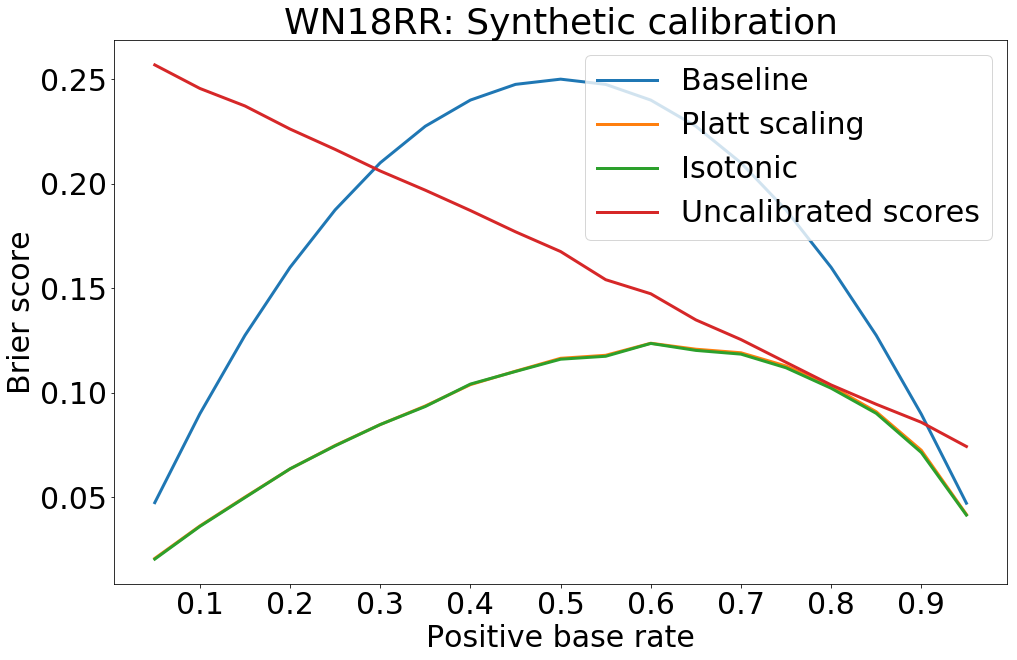

In [25]:
plt.figure(figsize=(16, 10))
plt.rcParams.update({'font.size': 30, 'axes.titlesize': 36})
plt.plot(bs.index, bs.baseline, lw=3, label="Baseline")
plt.plot(bs.index, bs.probas_pos, lw=3, label="Platt scaling")
plt.plot(bs.index, bs.probas_pos_iso, lw=3, label="Isotonic")
plt.plot(bs.index, bs.scores, lw=3, label="Uncalibrated scores")
plt.xlabel("Positive base rate")
plt.ylabel("Brier score")
plt.legend()
plt.xticks(np.linspace(0.1, 0.9, 9))
plt.title("WN18RR: Synthetic calibration")

In [18]:
ll = df[(c for c in df.columns if c.startswith('log_loss'))]
ll.columns = [c[len("log_loss_"):] for c in ll.columns]
ll.style.apply(highlight_min, axis=1)

,baseline,probas_pos,probas_pos_iso,probas_pos_sc,scores
0.05,0.198515,0.0961096,0.0938247,0.09609,0.713622
0.1,0.325083,0.154938,0.152141,0.154913,0.684181
0.15,0.422714,0.201868,0.198465,0.201829,0.660573
0.2,0.500402,0.243691,0.240363,0.243611,0.633744
0.25,0.562335,0.276116,0.272113,0.276041,0.607025
0.3,0.610882,0.298164,0.297295,0.298132,0.576455
0.35,0.647454,0.319378,0.318169,0.319362,0.55048
0.4,0.673012,0.348829,0.346331,0.348695,0.530171
0.45,0.68815,0.359231,0.357538,0.359132,0.501411
0.5,0.693147,0.375285,0.371032,0.375131,0.479337


Text(0.5, 1.0, 'WN18RR: Synthetic calibration')

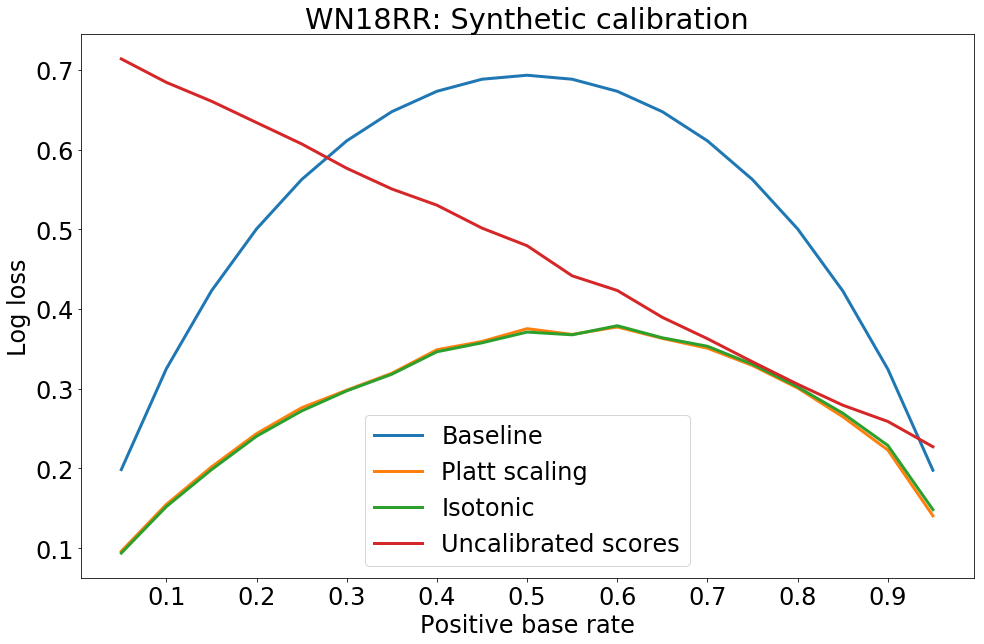

In [24]:
plt.figure(figsize=(16, 10))
plt.rcParams.update({'font.size': 24})
plt.plot(ll.index, ll.baseline, lw=3, label="Baseline")
plt.plot(ll.index, ll.probas_pos, lw=3, label="Platt scaling")
plt.plot(ll.index, ll.probas_pos_iso, lw=3, label="Isotonic")
plt.plot(ll.index, ll.scores, lw=3, label="Uncalibrated scores")
plt.xlabel("Positive base rate")
plt.ylabel("Log loss")
plt.legend()
plt.xticks(np.linspace(0.1, 0.9, 9))
plt.title("WN18RR: Synthetic calibration")